In [1]:
#________________imports________________

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import joblib
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable


#________________Functions________________

# converting image array into CIFAR-10 data format
# as the models have been trained in the form of CIFAR-10 data
def data_from_image_array(image_array):
    red, green, blue = [], [], []
    for i in image_array:
        for j in i:
            red.append(j[0])
            green.append(j[1])
            blue.append(j[2])
    return np.array(red+green+blue)

#prediction function for Logistics & XGB
def prediction(model, image):
    image_array = np.asarray(image)

    image_data = data_from_image_array(image_array)
    image_data_normalized = image_data / 255

    prediction = model.predict(np.array([image_data_normalized]))
    if prediction == 0: return 'animal'
    elif prediction==1: return 'vehicle'
    else: return None

#prediction function
def cnn_prediction(model, image):

    transformer = transforms.Compose(
     [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor.to(device)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    label_index = output.data.cpu().numpy()
    pred = 'vehicle' if label_index.item() >= 0 else 'animal'
    return pred

#Convlolutional Neural Network class
class ConvNet(nn.Module):
    def __init__(self, conv_kernel_size=3, pool_kernel_size=2, stride=1, padding=1):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=conv_kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=conv_kernel_size, stride=stride, padding=padding)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=conv_kernel_size, stride=stride, padding=padding)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()

        self.fc = nn.Linear(in_features=32 * 16 * 16, out_features=1)

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)

        output = output.view(-1, 32 * 16 * 16)
        output = self.fc(output)

        return output

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
#loading models

model1_1 = joblib.load("Saved Models/model1_1.sav")
model1_2 = joblib.load("Saved Models/model1_2.sav")
model1_3 = joblib.load("Saved Models/model1_3.sav")
model1 = joblib.load("Saved Models/model1.sav")

model2_1 = joblib.load("Saved Models/model2_1.sav")
model2_2 = joblib.load("Saved Models/model2_2.sav")
model2_3 = joblib.load("Saved Models/model2_3.sav")
model2 = joblib.load("Saved Models/model2.sav")

checkpoint1=torch.load('Saved Models/model3_1.pt', map_location=device)
model3_1=ConvNet(conv_kernel_size=3, pool_kernel_size=2, stride=1, padding=1)
model3_1.load_state_dict(checkpoint1)
model3_1.to(device)
model3_1.eval()

checkpoint2=torch.load('Saved Models/model3_2.pt', map_location=device)
model3_2=ConvNet(conv_kernel_size=5, pool_kernel_size=2, stride=1, padding=2)
model3_2.load_state_dict(checkpoint2)
model3_2.to(device)
model3_2.eval()

checkpoint3=torch.load('Saved Models/model3_3.pt', map_location=device)
model3_3=ConvNet(conv_kernel_size=7, pool_kernel_size=2, stride=1, padding=3)
model3_3.load_state_dict(checkpoint3)
model3_3.to(device)
model3_3.eval()

checkpoint=torch.load('Saved Models/CNN_best.pt', map_location=device)
model3=ConvNet()
model3.load_state_dict(checkpoint)
model3.to(device)
model3.eval()

models = np.array([[model1_1, model1_2, model1_3, model1],
                   [model2_1, model2_2, model2_3, model2],
                   [model3_1, model3_2, model3_3, model3] ] )

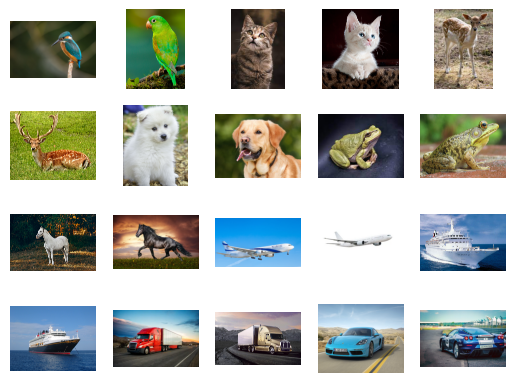

In [4]:
#opening images
images_large = []

for i in range(1,21):
    try: img_large = Image.open("Downloaded Images for Testing/" + str(i) + ".jpg")
    except: img_large = Image.open("Downloaded Images for Testing/" + str(i) + ".webp")
    images_large.append(img_large)

for i in range(20):
  plt.subplot(4, 5, i+1), plt.imshow(images_large[i]), plt.axis("off")

In [5]:
original = ['animal' for _ in range(12)] + ['vehicle' for _ in range(8)]

images = [ (i.resize((32,32))).convert('RGB') for i in images_large ]

m1_1 = [prediction(model1_1, i) for i in images]
m1_2 = [prediction(model1_2, i) for i in images]
m1_3 = [prediction(model1_3, i) for i in images]
m1 = [prediction(model1, i) for i in images]

m2_1 = [prediction(model2_1, i) for i in images]
m2_2 = [prediction(model2_2, i) for i in images]
m2_3 = [prediction(model2_3, i) for i in images]
m2 = [prediction(model2, i) for i in images]

m3_1 = [cnn_prediction(model3_1, i) for i in images]
m3_2 = [cnn_prediction(model3_2, i) for i in images]
m3_3 = [cnn_prediction(model3_3, i) for i in images]
m3 = [cnn_prediction(model3, i) for i in images]

results = pd.DataFrame({
    "Logistic-1 (model1_1)" : m1_1,
    "Logistic-2 (model1_2)" : m1_2,
    "Logistic-3 (model1_3)" : m1_3,
    "Best of Logistic (model1)" : m1,
    "XGBoost-1 (model2_1)" : m2_1,
    "XGBoost-2 (model2_2)" : m2_2,
    "XGBoost-3 (model2_3)" : m2_3,
    "Best of XGBoost (model2)" : m2,
    "CNN-1 (model3_1)" : m3_1,
    "CNN-2 (model3_2)" : m3_2,
    "CNN-3 (model3_3)" : m3_3,
    "Best of CNN (model3)" : m3 },
    index = ["Image "+str(i) for i in range(1, 21)],
)

results

,Logistic-1 (model1_1),Logistic-2 (model1_2),Logistic-3 (model1_3),Best of Logistic (model1),XGBoost-1 (model2_1),XGBoost-2 (model2_2),XGBoost-3 (model2_3),Best of XGBoost (model2),CNN-1 (model3_1),CNN-2 (model3_2),CNN-3 (model3_3),Best of CNN (model3)
Image 1,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal
Image 2,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal
Image 3,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal
Image 4,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal
Image 5,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal
Image 6,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal
Image 7,animal,animal,animal,animal,animal,vehicle,animal,animal,animal,animal,animal,animal
Image 8,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal
Image 9,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal
Image 10,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal,animal
